# 6. 프로젝트: 멋진 작사가 만들기

## Step 1. 데이터 다운로드  
먼저 아래 링크에서 Song Lyrics 데이터를 다운로드  
저장된 파일을 압축 해제한 후, 모든 txt 파일을 lyrics 폴더를 만들어 그 속에 저장  
* Song Lyrics  

## Step 2. 데이터 읽어오기
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기  
glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장

In [1]:
import glob
import os
import re                  # 정규표현식을 위한 Regex 지원 모듈 (문장 데이터를 정돈하기 위해) 
import numpy as np         # 변환된 문장 데이터(행렬)을 편하게 처리하기 위해
import tensorflow as tf    # 대망의 텐서플로우!

from tensorflow import keras


txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['Ooh....... New York x2 Grew up in a town that is famous as a place of movie scenes', 'Noise is always loud, there are sirens all around and the streets are mean', "If I can make it here, I can make it anywhere, that's what they say"]


## Step 3. 데이터 정제  
* 앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제  
* preprocess_sentence() 함수를 활용해 데이터를 정제  
* 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거  
* 토큰의 개수가 15개를 넘어가는 문장을 학습데이터에서 제외  

In [2]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(idx,sentence)

0 Ooh....... New York x2 Grew up in a town that is famous as a place of movie scenes
1 Noise is always loud, there are sirens all around and the streets are mean
2 If I can make it here, I can make it anywhere, that's what they say
3 Seeing my face in lights or my name on marquees found down on Broadway Even if it ain't all it seems, I got a pocket full of dreams
4 Baby, I'm from New York
5 Concrete jungle where dreams are made of
6 There's nothing you can't do
7 Now you're in New York
8 These streets will make you feel brand new
9 Big lights will inspire you


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       
    # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀝니다.
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        
    # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  
    # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  
    # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      
    # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙여 줍니다
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))   
# 이 문장이 어떻게 필터링되는지 확인해 보세요.

<start> this is sample sentence . <end>


In [4]:
# 문장 길이 긴 것 빼고 다시 
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if len(sentence) > 15: continue
    if sentence[-1] == ":": continue    
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> oh , oh , oh , <end>',
 '<start> you can be sure <end>',
 '<start> oh oh oh oh <end>',
 '<start> oh oh oh oh <end>',
 '<start> oh oh oh oh <end>',
 '<start> oh , oh , oh , <end>',
 '<start> you can be sure <end>',
 '<start> oh oh oh oh <end>',
 '<start> oh oh oh oh <end>',
 '<start> oh oh oh oh <end>']

In [5]:
total_data_text = list(corpus)

#텍스트 데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

#문장 길이의 평균값, 최대값, 표준편차를 계산
print("문장 길이의 평균 : ", np.mean(num_tokens))
print("문장 길이의 최대 : ", np.max(num_tokens))
print("문장 길이 표준 편차 : ", np.std(num_tokens))

#최대 길이 (평균 + 4*표준편차) 너무 길면 시간이 오래 걸린다. 
max_tokens = np.mean(num_tokens) +4*np.std(num_tokens)
maxlen = int(max_tokens)
print("pad_sequences maxlen : ", maxlen)
print("전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.".format(np.sum(num_tokens<max_tokens)/len(num_tokens)))

문장 길이의 평균 :  24.541784702549574
문장 길이의 최대 :  35
문장 길이 표준 편차 :  3.6829496414281495
pad_sequences maxlen :  39
전체 문장의 1.0%가 maxlen 설정값 이내에 포함됩니다.


/home/aiffel-dj56/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


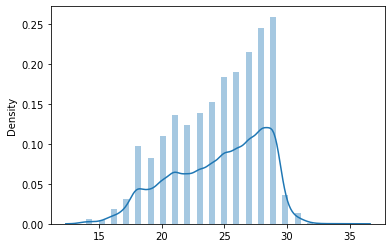

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

#문장 길이 분포 확인
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['grid.color'] = '#F0F0F0'
plt.rcParams['grid.linestyle'] = 'solid'
sns.distplot(num_tokens)
plt.style.use("bmh")
plt.show()

In [7]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen = 15, padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2    8    5 ...    0    0    0]
 [   2    7   39 ...    0    0    0]
 [   2    8    8 ...    0    0    0]
 ...
 [   2   93  111 ...    0    0    0]
 [   2  953    6 ...    0    0    0]
 [   2 1643   90 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fd6c13d3310>


In [8]:
print(tensor[:3, :10])

[[  2   8   5   8   5   8   5   3   0   0]
 [  2   7  39  48 489   3   0   0   0   0]
 [  2   8   8   8   8   3   0   0   0   0]]


In [9]:
#데이터 길이 확인
len(tensor[1])

15

In [10]:
tensor[1]

array([  2,   7,  39,  48, 489,   3,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [11]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break
     
print(len(tokenizer.index_word))

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : .
7 : you
8 : oh
9 : it
10 : me
3416


In [12]:
src_input = tensor[:, :-1]  
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 
#마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[2 8 5 8 5 8 5 3 0 0 0 0 0 0]
[8 5 8 5 8 5 3 0 0 0 0 0 0 0]


In [13]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE
print(BUFFER_SIZE)

print(steps_per_epoch)
VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
print(VOCAB_SIZE)

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

14120
55
12001


<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## Step 4. 평가 데이터셋 분리

* 훈련 데이터와 평가 데이터를 분리  
* tokenize() 함수로 데이터를 Tensor로 변환한 후,  
* sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리  
* 단어장의 크기는 12,000 이상으로 설정
* 총 데이터의 20%를 평가 데이터셋으로 사용

enc_train, enc_val, dec_train, dec_val = <코드 작성>  
여기까지 올바르게 진행했을 경우, 아래 실행 결과를 확인  

print("Source Train:", enc_train.shape)  
print("Target Train:", dec_train.shape)  
out:  

Source Train: (124960, 14)  
Target Train: (124960, 14)  

In [14]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2)
print("Source Train:", enc_train.shape)  
print("Target Train:", dec_train.shape)  

#학습데이터 갯수 124960보다 작은 결과

Source Train: (11296, 14)
Target Train: (11296, 14)


## Step 5. 인공지능 만들기  
모델의 Embedding Size와 Hidden Size를 조절  
10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계  
(Loss는 아래 제시된 Loss 함수를 그대로 사용!)   
멋진 모델이 생성한 가사 한 줄을 제출  

In [15]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [16]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 2.51281872e-05,  3.84564599e-04, -8.45932518e-05, ...,
          5.38982895e-05,  6.12864242e-05, -6.96704001e-06],
        [-1.01457059e-04,  4.67945385e-04, -2.53133127e-04, ...,
          4.60407929e-04, -7.59436880e-05,  5.54663893e-05],
        [-3.33604345e-04,  5.48078038e-04, -2.28889214e-04, ...,
          6.68782857e-04, -1.85930694e-04,  3.41390230e-04],
        ...,
        [-2.00391933e-03,  3.37700767e-04, -1.82372413e-03, ...,
         -2.47789873e-03,  1.24888471e-03, -4.78060865e-05],
        [-2.33704154e-03,  3.55865428e-04, -1.96975120e-03, ...,
         -2.71337503e-03,  1.27004727e-03, -1.29208071e-04],
        [-2.61787721e-03,  3.77870456e-04, -2.10872805e-03, ...,
         -2.86525488e-03,  1.24442461e-03, -2.19340582e-04]],

       [[ 2.51281872e-05,  3.84564599e-04, -8.45932518e-05, ...,
          5.38982895e-05,  6.12864242e-05, -6.96704001e-06],
        [ 2.79867963e-04,  3.25817266e-04,  4

In [17]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [18]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(dataset, epochs=30)

Epoch 1/30
55/55 [==============================] - 7s 120ms/step - loss: 2.5496
Epoch 2/30
55/55 [==============================] - 7s 120ms/step - loss: 1.4538
Epoch 3/30
55/55 [==============================] - 7s 124ms/step - loss: 1.2562
Epoch 4/30
55/55 [==============================] - 7s 124ms/step - loss: 1.2022
Epoch 5/30
55/55 [==============================] - 7s 122ms/step - loss: 1.1765
Epoch 6/30
55/55 [==============================] - 7s 119ms/step - loss: 1.1555
Epoch 7/30
55/55 [==============================] - 7s 122ms/step - loss: 1.1325
Epoch 8/30
55/55 [==============================] - 7s 119ms/step - loss: 1.1082
Epoch 9/30
55/55 [==============================] - 7s 119ms/step - loss: 1.0825
Epoch 10/30
55/55 [==============================] - 7s 119ms/step - loss: 1.0611
Epoch 11/30
55/55 [==============================] - 7s 119ms/step - loss: 1.0383
Epoch 12/30
55/55 [==============================] - 7s 120ms/step - loss: 1.0185
Epoch 13/30
55/55 [======

In [19]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss'])


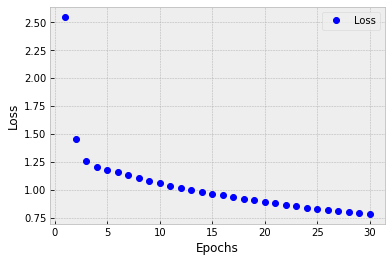

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['loss']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = "Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, 
                                                                 tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [22]:
#Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

#results = model.evaluate(dec_train, dec_val, verbose = 2)
#print(results)

#enc_train, enc_val, dec_train, dec_val

In [23]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you <end> '

In [24]:
generate_text(model, tokenizer, init_sentence="<start> love is", max_len=20)

'<start> love is it <end> '

# ◈ 루브릭  

아래의 기준을 바탕으로 프로젝트를 평가합니다.  

평가문항/상세기준  
1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?  
텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가? 


2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?  
특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?  


3. 텍스트 생성모델이 안정적으로 학습되었는가?  
텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?  

# ◈ 결론 및 고찰 

이전에 사용한 txt 파일 보다 더 풍부한 데이터를 사용하여 사전 Index를 만들고, 임베딩 벡터를 만들고, 학습을 해본 결과 start 단어 뒤에 오는 문장이 훨씬 자연스러워 짐을 알 수 있었다.
예를 들어 이전에는 `i love` 를 입력했을 때 출력되는 값이 `i love thee not a jar o the clock behind` 였으나, 현재 개선된 학습 모델에서는 `i love`에 대해 `i love you`라고 답변이 나오고, `love is`에 대해서는 `love is it` 이라는 결과가 나옴을 알 수 있었다.   
사용되는 정보의 양과 질이 좀더 결과에 좋은 영향을 미치지 않았나 생각해 보며, 또한 15개를 넘어가는 문장을 학습데이터에서 제외하고, 사전의 개수도 `7000에서 12000`으로 늘어난 것도 영향이 있다고 생각된다.  
`loss결과`는 epoch가 10회 이상부터 1아래로 떨어지는 경향을 보였으면 적어도 10회 가량의 모델 fit이 필요하다고 생각된다.